##############################
# Diabete Feature Engineering
##############################

# Problem : Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirilmesi
# istenmektedir. Modeli geliştirmeden önce gerekli olan veri analizi ve özellik mühendisliği adımlarını gerçekleştirmeniz beklenmektedir.

# Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır.
# ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları
# üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır.
# Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

# Pregnancies: Hamilelik sayısı
# Glucose: Glikoz
# BloodPressure: Kan basıncı (Diastolic(Küçük Tansiyon))
# SkinThickness: Cilt Kalınlığı
# Insulin: İnsülin.
# BMI: Beden kitle indeksi.
# DiabetesPedigreeFunction: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
# Age: Yaş (yıl)
# Outcome: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

In [6]:
!pip install missingno

In [8]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

sys.path.append('/workspaces/feature-engineering/src')
from getcsv_data import get_dataset
from examine_data import check_df
from classify_data import grab_col_names
from analyze_data import cat_summary,num_summary,target_summary_with_num,target_summary_with_cat,missing_value,missing_value_and_target,corr_variable
from analyze_data import outlier_thr, check_outlier, replace_with_thresholds
from analyze_data import corr_variable
from extract_feature import set_insulin, set_age, set_BMI, set_Glucose, set_age_BMI, set_age_Glucose
from encoding import label_encoding, one_hot_encoding
from feature_importance import feature_importance_plot


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x) #virgülden sonra 3 basamak
pd.set_option('display.width', 500)

path="/workspaces/feature-engineering/datasets/diabetes.csv"



In [9]:
df = get_dataset(path)
df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.600,0.627,50,tested_positive
1,1,85,66,29,0,26.600,0.351,31,tested_negative
2,8,183,64,0,0,23.300,0.672,32,tested_positive
3,1,89,66,23,94,28.100,0.167,21,tested_negative
4,0,137,40,35,168,43.100,2.288,33,tested_positive


In [10]:
df.columns=["Pregnancies","Glucose","Blood","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age","Outcome"]
labelencoder = LabelEncoder()
df["Outcome"] = labelencoder.fit_transform(df["Outcome"])
df.head()

,Pregnancies,Glucose,Blood,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


# GÖREV 1: KEŞİFCİ VERİ ANALİZİ
           # Adım 1: Genel resmi inceleyiniz.
           # Adım 2: Numerik ve kategorik değişkenleri yakalayınız.
           # Adım 3:  Numerik ve kategorik değişkenlerin analizini yapınız.
           # Adım 4: Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)
           # Adım 5: Aykırı gözlem analizi yapınız.
           # Adım 6: Eksik gözlem analizi yapınız.
           # Adım 7: Korelasyon analizi yapınız.

In [11]:
# Adım 1: Genel resmi inceleyiniz.
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
Blood                         int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  Blood  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148     72             35        0 33.600                     0.627   50        1
1            1       85     66             29        0 26.600                     0.351   31        0
2            8      183     64              0        0 23.300                     0.672   32        1
3            1       89     66             23       94 28.100                     0.167   21    

Hiç boş değer gözükmüyor.
Fakat Quantiles da her bir değişkenin minimum değerine baktığımızda blood,skinthickness gibi değişkenlerde 0 değeri mevcut ki bu 
gerçekte olmayacak bir durum. Bu yüzden boş değerlerin 0 ile doldurulmuş olması olası.
Buna ek olarak %99 ile %100 yani max değeri arasında ciddi artış olanlarda aykırı değer olma durumu olası.

In [12]:
# Adım 2: Numerik ve kategorik değişkenleri yakalayınız.

cat_cols, num_cols, cat_but_car = grab_col_names(df)

print(f'cat_cols: {cat_cols}')
print(f'num_cols: {num_cols}')
print(f'cat_but_car: {cat_but_car}')


Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1
cat_cols: ['Outcome']
num_cols: ['Pregnancies', 'Glucose', 'Blood', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
cat_but_car: []


Toplam 9 feature ın 8'i numerik, 1 i kategorik feature dır. num_but_cat zaten cat_cols a dahildir.

   Outcome  Ratio
0      500 65.104
1      268 34.896
##########################################
count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64


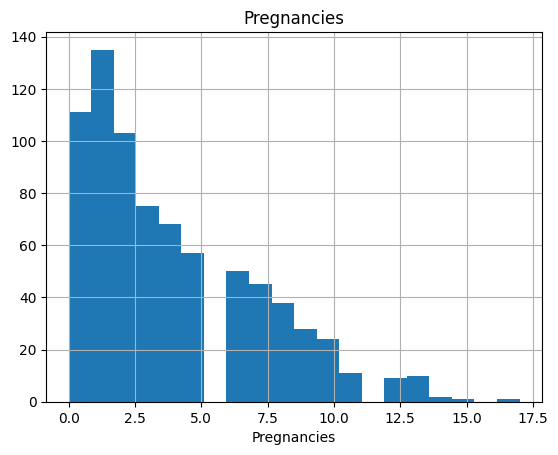

count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64


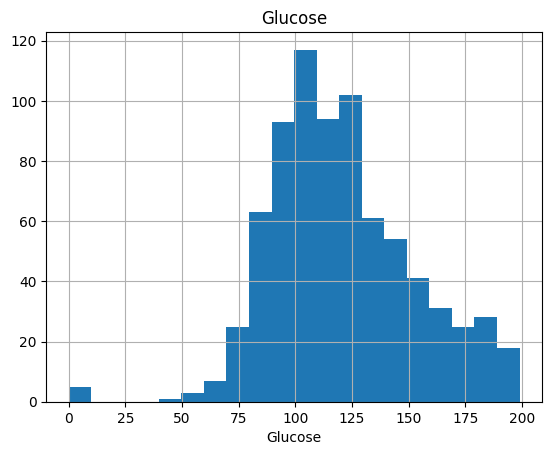

count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: Blood, dtype: float64


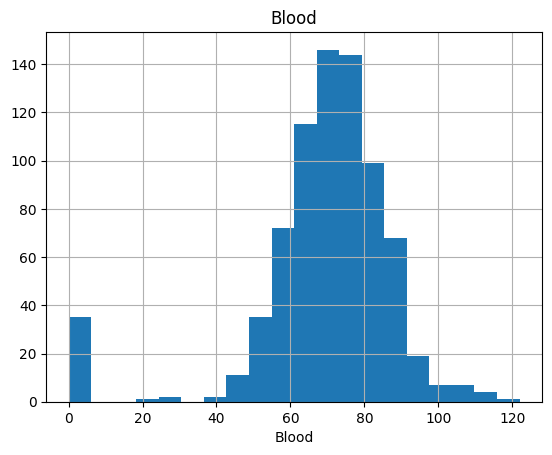

count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       8.200
40%      18.000
50%      23.000
60%      27.000
70%      31.000
80%      35.000
90%      40.000
95%      44.000
99%      51.330
max      99.000
Name: SkinThickness, dtype: float64


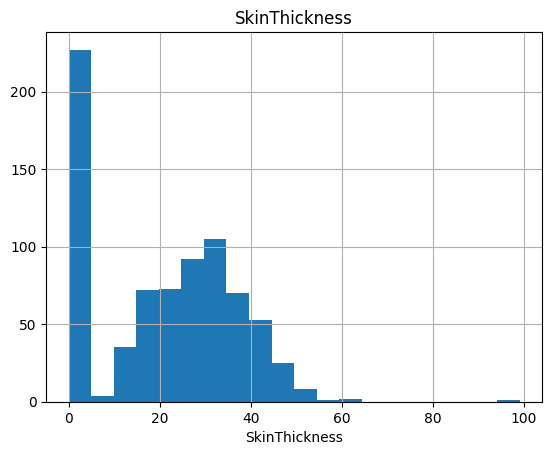

count   768.000
mean     79.799
std     115.244
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       0.000
50%      30.500
60%      72.200
70%     106.000
80%     150.000
90%     210.000
95%     293.000
99%     519.900
max     846.000
Name: Insulin, dtype: float64


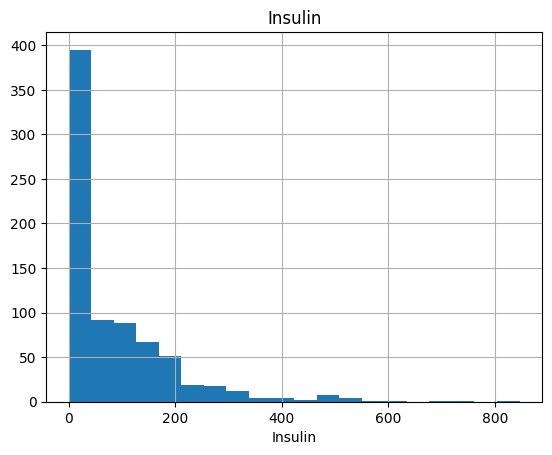

count   768.000
mean     31.993
std       7.884
min       0.000
5%       21.800
10%      23.600
20%      25.900
30%      28.200
40%      30.100
50%      32.000
60%      33.700
70%      35.490
80%      37.800
90%      41.500
95%      44.395
99%      50.759
max      67.100
Name: BMI, dtype: float64


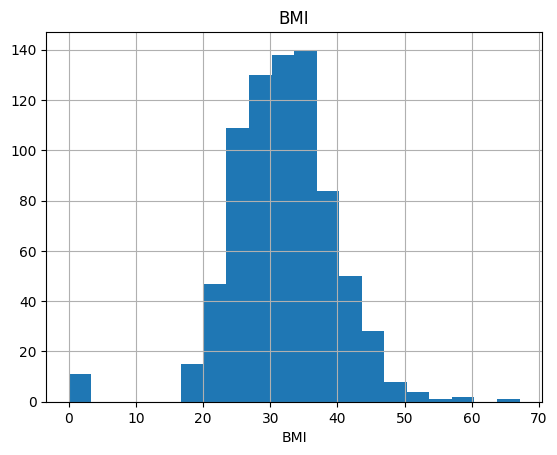

count   768.000
mean      0.472
std       0.331
min       0.078
5%        0.140
10%       0.165
20%       0.219
30%       0.259
40%       0.303
50%       0.372
60%       0.454
70%       0.564
80%       0.687
90%       0.879
95%       1.133
99%       1.698
max       2.420
Name: DiabetesPedigreeFunction, dtype: float64


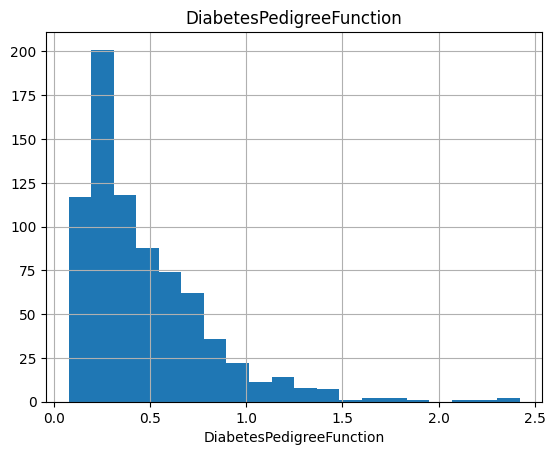

count   768.000
mean     33.241
std      11.760
min      21.000
5%       21.000
10%      22.000
20%      23.000
30%      25.000
40%      27.000
50%      29.000
60%      33.000
70%      38.000
80%      42.600
90%      51.000
95%      58.000
99%      67.000
max      81.000
Name: Age, dtype: float64


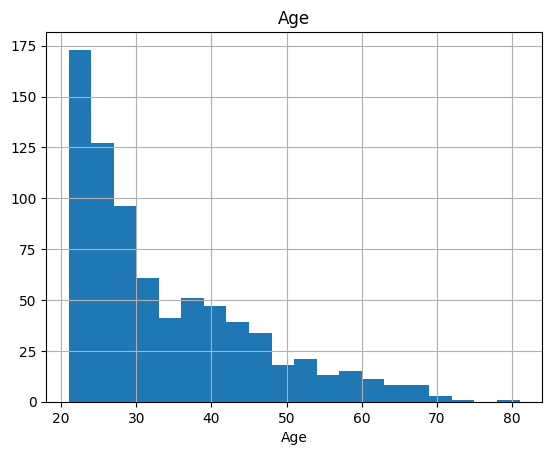

In [13]:
# Adım 3:  Numerik ve kategorik değişkenlerin analizini yapınız.

cat_summary(df, "Outcome")

for col in num_cols:
    num_summary(df, col, plot=True)


# 768 gözleme ait Target(outcome) incelendiğinde; %34.896 oranında diyabet hastası oldukları,
# SkinThickness: max değer ile %99 çeyreklik değeri arasında ciddi bir sıçrama olmasından kaynaklı aykırı değerlerin olabileceği,
# Insulin: İnsulin değerinde, std nin meanden ciddi anlamda farklı olması ve max değer ile %99 çeyreklik değeri arasında ciddi bir sıçrama olmasından kaynaklı aykırı değerlerin olabileceği
# gözlemlenmiştir.

In [14]:
# Adım 4: Hedef değişken analizi yapınız. (Kategorik değişkenlere göre hedef değişkenin ortalaması, hedef değişkene göre numerik değişkenlerin ortalaması)

for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         Blood
Outcome       
0       68.184
1       70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




diabet olanların yaş ortalaması 37.067 iken diabet olmayanların yaş ortalaması 31.190 dır.

In [15]:
for col in cat_cols:
    target_summary_with_cat(df, "Outcome", col) #zaten bir kategorik değişken yok

         OUTCOME_MEAN
Outcome              
0               0.000
1               1.000




In [16]:
#Adım 6: Eksik gözlem analizi yapınız.

# eksik gozlem var mı yok mu sorgusu
df.isnull().values.any()

False

In [17]:
# degiskenlerdeki eksik deger sayisi
df.isnull().sum()

Pregnancies                 0
Glucose                     0
Blood                       0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [18]:
#eksik değerlerin gözlem içindeki oranı
(df.isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)

Pregnancies                0.000
Glucose                    0.000
Blood                      0.000
SkinThickness              0.000
Insulin                    0.000
BMI                        0.000
DiabetesPedigreeFunction   0.000
Age                        0.000
Outcome                    0.000
dtype: float64

In [19]:
#eksik gözlemi olan değişken isimleri
na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
print(na_cols)

[]


bu datada eksik gözlem -nan olan gözlem mevcut değildir. O zaman 0 ları analiz etmeliyiz. Boş değerleri 0 ile doldurdukları, Glucose,Blood,SkinThickness=0 ,Insulin,BMI,DiabetesPedigreeFunction, Age =0 olma gibi durum mümkün olmadığı düşünülmektedir. Oyüzden 0 olanları NAN değerine dönüştürmeliyiz.

In [20]:
zero_columns = [col for col in df.columns if (df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]
# Gözlem birimlerinde 0 olan degiskenlerin her birisine gidip 0 iceren gozlem degerlerini NaN ile değiştirdik.
for col in zero_columns:
    df[col] = np.where(df[col] == 0, np.nan, df[col])

NAN değerler atandıktan sonra eksik gözlem analiz adımlarını tekrar edelim.

In [21]:
# Eksik Gözlem Analizi
df.isnull().sum()

Pregnancies                   0
Glucose                       5
Blood                        35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [22]:
#eksik değerlerin gözlem içindeki oranı
(df.isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)

Insulin                    48.698
SkinThickness              29.557
Blood                       4.557
BMI                         1.432
Glucose                     0.651
Pregnancies                 0.000
DiabetesPedigreeFunction    0.000
Age                         0.000
Outcome                     0.000
dtype: float64

In [23]:
na_columns = missing_value(df, na_name=True)
print(na_columns)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
Blood              35  4.560
BMI                11  1.430
Glucose             5  0.650
['Glucose', 'Blood', 'SkinThickness', 'Insulin', 'BMI']


In [24]:
#eksik değerlerin hedef değişken ile olan ilişki analizi için;

#Glucose_NA_FLAG=1 => Glucose u boş olan gözlem sayısı=5.glocose u boş olan kişilerin Diabet hastası olma oranı %40 (5 kişinin %40 ı diabet hastası)
#Glucose_NA_FLAG=0 => Glucose u boş olmayan gözlem sayısı=763.glocose u dolu olan kişilerin Diabet hastası olma oranı %34 (763 kişinin %34 ü diabet hastası)

missing_value_and_target(df, "Outcome", na_columns)

                 TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                      0.349    763
1                      0.400      5


               TARGET_MEAN  Count
Blood_NA_FLAG                    
0                    0.344    733
1                    0.457     35


                       TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                            0.333    541
1                            0.388    227


                 TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                      0.330    394
1                      0.369    374


             TARGET_MEAN  Count
BMI_NA_FLAG                    
0                  0.351    757
1                  0.182     11




Insulin_NA_FLAG da boş olanlar(=1) ile dolu olanlar(=0) arasında oransal ve sayısal bir fark çok yok o yüzden hedef değişkeni çok da etkilemez diye bir varsayımda bulunabiliriz. SkinThickness_NA_FLAG da da oransal çok bir fark yok ama sayıca da çoklar.

In [25]:
# Eksik Değerlerin MEDYAN Doldurulması
for col in zero_columns:
    df.loc[df[col].isnull(), col] = df[col].median()


df.isnull().sum()

Pregnancies                 0
Glucose                     0
Blood                       0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [26]:
#Adım 5: Aykırı gözlem analizi yapınız.

# Aykırı Değer Analizi ve Baskılama İşlemi
for col in df.columns:
    print(col, check_outlier(df, col))
    if check_outlier(df, col):
        replace_with_thresholds(df, col)
print("##########################################")
#outlierlar baskılandıktan sonra outlier kaldı mı kontrolü yapılır
for col in df.columns:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
Blood False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False
##########################################
Pregnancies False
Glucose False
Blood False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


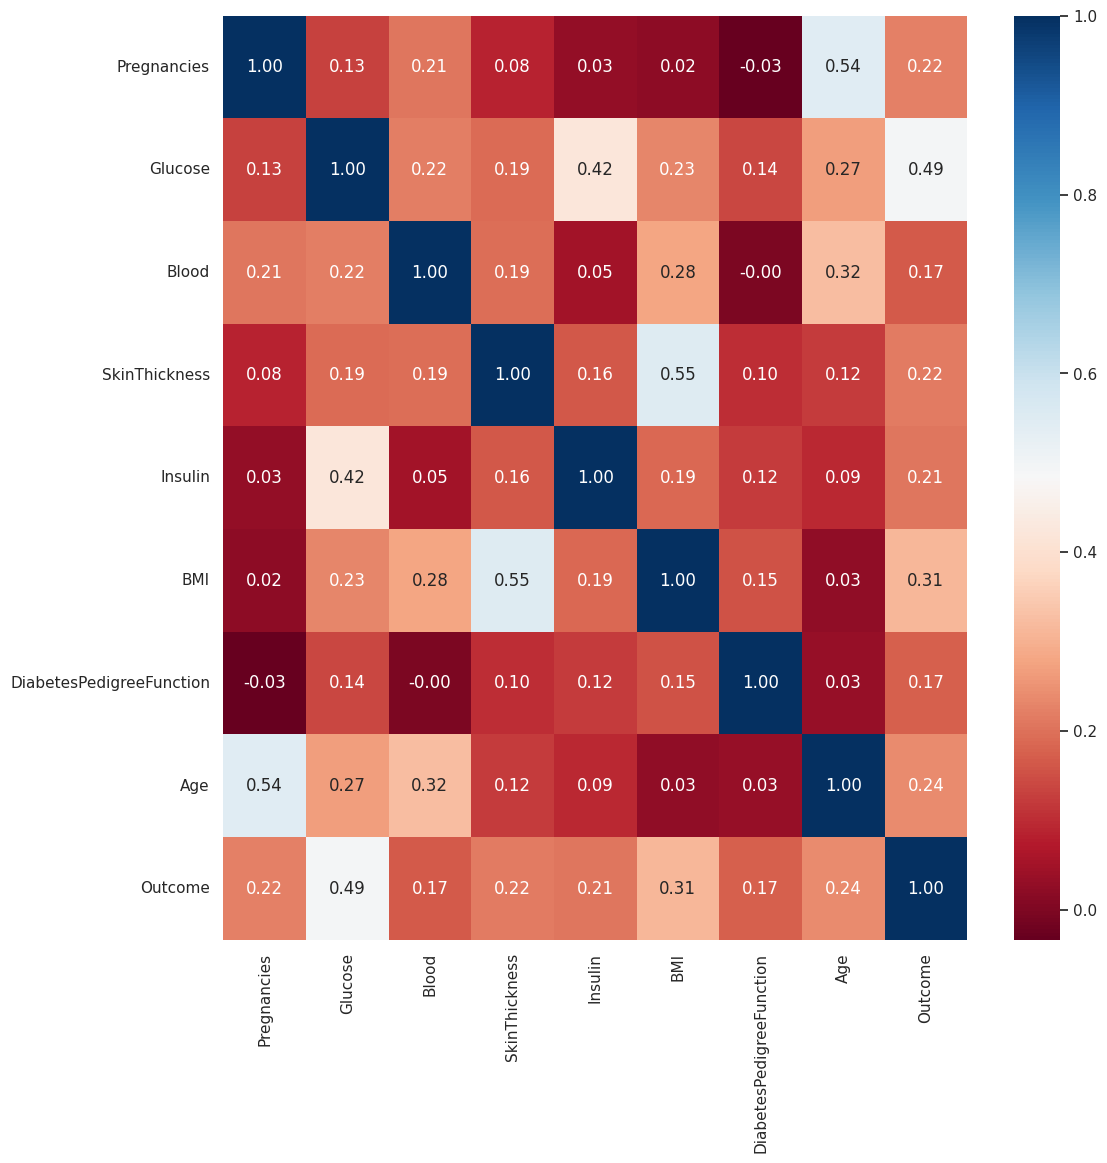

In [27]:
corr_variable(df)

Outcome ile Glucose,age arasında ciddi bir ilişki gözüküyor. bu oranlar %95 ve üstüne ulaştığında bu değişkenlerin aynı şeyi ifade ettiğini düşünebilirdik.


In [28]:
# Adım 2: Yeni değişkenler oluşturunuz.Feature Extraction
df["NEW_INSULIN_SCORE"] = df.apply(set_insulin, axis=1)
df.head()

,Pregnancies,Glucose,Blood,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_INSULIN_SCORE
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,Normal
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,Normal
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,Normal
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Normal
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Abnormal


In [29]:
df["NEW_AGE_CAT"] = df.apply(set_age, axis=1)
df.head()

,Pregnancies,Glucose,Blood,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_INSULIN_SCORE,NEW_AGE_CAT
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,Normal,senior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,Normal,mature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,Normal,mature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Normal,mature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Abnormal,mature


In [30]:
df = set_BMI(df, "BMI")
df.head()

,Pregnancies,Glucose,Blood,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_INSULIN_SCORE,NEW_AGE_CAT,NEW_BMI
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,Normal,senior,Obese
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,Normal,mature,Overweight
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,Normal,mature,Healthy
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Normal,mature,Overweight
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Abnormal,mature,Obese


In [31]:
df = set_Glucose(df, "Glucose")
df.head()

,Pregnancies,Glucose,Blood,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_INSULIN_SCORE,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,Normal,senior,Obese,Prediabetes
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,Normal,mature,Overweight,Normal
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,Normal,mature,Healthy,Prediabetes
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Normal,mature,Overweight,Normal
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Abnormal,mature,Obese,Normal


In [32]:
df["NEW_AGE_BMI_NOM"] = df.apply(set_age_BMI, axis=1)
df.head()

,Pregnancies,Glucose,Blood,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_INSULIN_SCORE,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,Normal,senior,Obese,Prediabetes,obesesenior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,Normal,mature,Overweight,Normal,overweightmature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,Normal,mature,Healthy,Prediabetes,healthymature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Normal,mature,Overweight,Normal,overweightmature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Abnormal,mature,Obese,Normal,obesemature


In [33]:
df["NEW_AGE_GLUCOSE_NOM"] = df.apply(set_age_Glucose, axis=1)
df.head()

,Pregnancies,Glucose,Blood,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_INSULIN_SCORE,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,Normal,senior,Obese,Prediabetes,obesesenior,highsenior
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,Normal,mature,Overweight,Normal,overweightmature,normalmature
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,Normal,mature,Healthy,Prediabetes,healthymature,highmature
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,Normal,mature,Overweight,Normal,overweightmature,normalmature
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,Abnormal,mature,Obese,Normal,obesemature,highmature


In [34]:
df["NEW_GLUCOSE*INSULIN"] = df["Glucose"] * df["Insulin"] 
#glikoz ve insulinin aynı şeyler olduğunu düşündüğümüzden çarparak kullanırsak bir etkisi olur mu diye bu değişkeni yaratıyoruz.



In [35]:

# sıfır olan değerler dikkat!!!!
df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * df["Pregnancies"]
#df["NEW_GLUCOSE*PREGNANCIES"] = df["Glucose"] * (1+ df["Pregnancies"])
#glikoz ve hamileliğin birbiriyle ilişkisi var mı diye inceleyeceğiz

In [36]:

# Kolonların büyültülmesi
df.columns = [col.upper() for col in df.columns]

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   PREGNANCIES               768 non-null    int64   
 1   GLUCOSE                   768 non-null    float64 
 2   BLOOD                     768 non-null    float64 
 3   SKINTHICKNESS             768 non-null    float64 
 4   INSULIN                   768 non-null    float64 
 5   BMI                       768 non-null    float64 
 6   DIABETESPEDIGREEFUNCTION  768 non-null    float64 
 7   AGE                       768 non-null    int64   
 8   OUTCOME                   768 non-null    int64   
 9   NEW_INSULIN_SCORE         768 non-null    object  
 10  NEW_AGE_CAT               768 non-null    object  
 11  NEW_BMI                   768 non-null    category
 12  NEW_GLUCOSE               768 non-null    category
 13  NEW_AGE_BMI_NOM           768 non-null    object  

In [37]:
#GÖREV 2: Adım 3: Encoding işlemlerini gerçekleştiriniz.

# Yeni oluşturulan değişkenlerin de tiplerine göre ayrılması işlemi
cat_cols, num_cols, cat_but_car = grab_col_names(df)
print(f'cat_cols: {cat_cols}')
print(f'num_cols: {num_cols}')
print(f'cat_but_car: {cat_but_car}')

Observations: 768
Variables: 17
cat_cols: 7
num_cols: 10
cat_but_car: 0
num_but_cat: 3
cat_cols: ['NEW_INSULIN_SCORE', 'NEW_AGE_CAT', 'NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'OUTCOME', 'NEW_BMI', 'NEW_GLUCOSE']
num_cols: ['PREGNANCIES', 'GLUCOSE', 'BLOOD', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'NEW_GLUCOSE*INSULIN', 'NEW_GLUCOSE*PREGNANCIES']
cat_but_car: []


In [38]:
#LABEL ENCODING

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['NEW_INSULIN_SCORE', 'NEW_AGE_CAT']

In [39]:
for col in binary_cols:
    df = label_encoding(df, col)

In [40]:
df.head()

,PREGNANCIES,GLUCOSE,BLOOD,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_INSULIN_SCORE,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,1,Obese,Prediabetes,obesesenior,highsenior,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,1,0,Overweight,Normal,overweightmature,normalmature,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,1,0,Healthy,Prediabetes,healthymature,highmature,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,1,0,Overweight,Normal,overweightmature,normalmature,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,0,Obese,Normal,obesemature,highmature,23016.000,0.000


In [41]:
# One-Hot Encoding İşlemi
# cat_cols listesinin güncelleme işlemi

cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]
cat_cols

['NEW_AGE_BMI_NOM', 'NEW_AGE_GLUCOSE_NOM', 'NEW_BMI', 'NEW_GLUCOSE']

In [42]:
df = one_hot_encoding(df, cat_cols, drop_first=True)

df.head()

,PREGNANCIES,GLUCOSE,BLOOD,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_INSULIN_SCORE,NEW_AGE_CAT,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_healthysenior,NEW_AGE_BMI_NOM_obesemature,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_overweightmature,NEW_AGE_BMI_NOM_overweightsenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50,1,1,1,18500.000,888.000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31,0,1,0,10625.000,85.000,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32,1,1,0,22875.000,1464.000,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0,1,0,8366.000,89.000,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1,0,0,23016.000,0.000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [43]:
# GÖREV2: Adım 4: Numerik değişkenler için standartlaştırma yapınız.
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOOD',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE*INSULIN',
 'NEW_GLUCOSE*PREGNANCIES']

In [44]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

,PREGNANCIES,GLUCOSE,BLOOD,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_INSULIN_SCORE,NEW_AGE_CAT,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_healthysenior,NEW_AGE_BMI_NOM_obesemature,NEW_AGE_BMI_NOM_obesesenior,NEW_AGE_BMI_NOM_overweightmature,NEW_AGE_BMI_NOM_overweightsenior,NEW_AGE_BMI_NOM_underweightmature,NEW_AGE_GLUCOSE_NOM_hiddensenior,NEW_AGE_GLUCOSE_NOM_highmature,NEW_AGE_GLUCOSE_NOM_highsenior,NEW_AGE_GLUCOSE_NOM_lowmature,NEW_AGE_GLUCOSE_NOM_lowsenior,NEW_AGE_GLUCOSE_NOM_normalmature,NEW_AGE_GLUCOSE_NOM_normalsenior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes
0,0.640,0.866,-0.032,0.680,-0.183,0.167,0.468,1.426,1,1,1,0.024,0.882,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
1,-0.845,-1.205,-0.528,-0.011,-0.183,-0.852,-0.365,-0.191,0,1,0,-0.503,-0.858,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1.234,2.017,-0.694,-0.011,-0.183,-1.333,0.604,-0.106,1,1,0,0.317,2.129,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
3,-0.845,-1.074,-0.528,-0.702,-0.553,-0.634,-0.921,-1.042,0,1,0,-0.654,-0.849,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,-1.142,0.504,-2.679,0.680,0.331,1.549,5.485,-0.020,1,0,0,0.326,-1.042,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [45]:
df.shape

(768, 31)

In [47]:
#GÖREV2: Adım 5: Model oluşturunuz.

y = df["OUTCOME"]
X = df.drop("OUTCOME", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.77
Recall: 0.684
Precision: 0.64
F1: 0.66
Auc: 0.75


    Value                            Feature
10  0.147                NEW_GLUCOSE*INSULIN
1   0.119                            GLUCOSE
7   0.096                                AGE
5   0.095                                BMI
11  0.091            NEW_GLUCOSE*PREGNANCIES
6   0.091           DIABETESPEDIGREEFUNCTION
2   0.057                              BLOOD
0   0.054                        PREGNANCIES
3   0.053                      SKINTHICKNESS
4   0.051                            INSULIN
28  0.036            NEW_GLUCOSE_Prediabetes
19  0.023     NEW_AGE_GLUCOSE_NOM_highmature
23  0.019   NEW_AGE_GLUCOSE_NOM_normalmature
13  0.010        NEW_AGE_BMI_NOM_obesemature
27  0.010                      NEW_BMI_Obese
25  0.008                    NEW_BMI_Healthy
8   0.007                  NEW_INSULIN_SCORE
26  0.005                 NEW_BMI_Overweight
15  0.005   NEW_AGE_BMI_NOM_overweightmature
16  0.004   NEW_AGE_BMI_NOM_overweightsenior
9   0.004                        NEW_AGE_CAT
20  0.004 

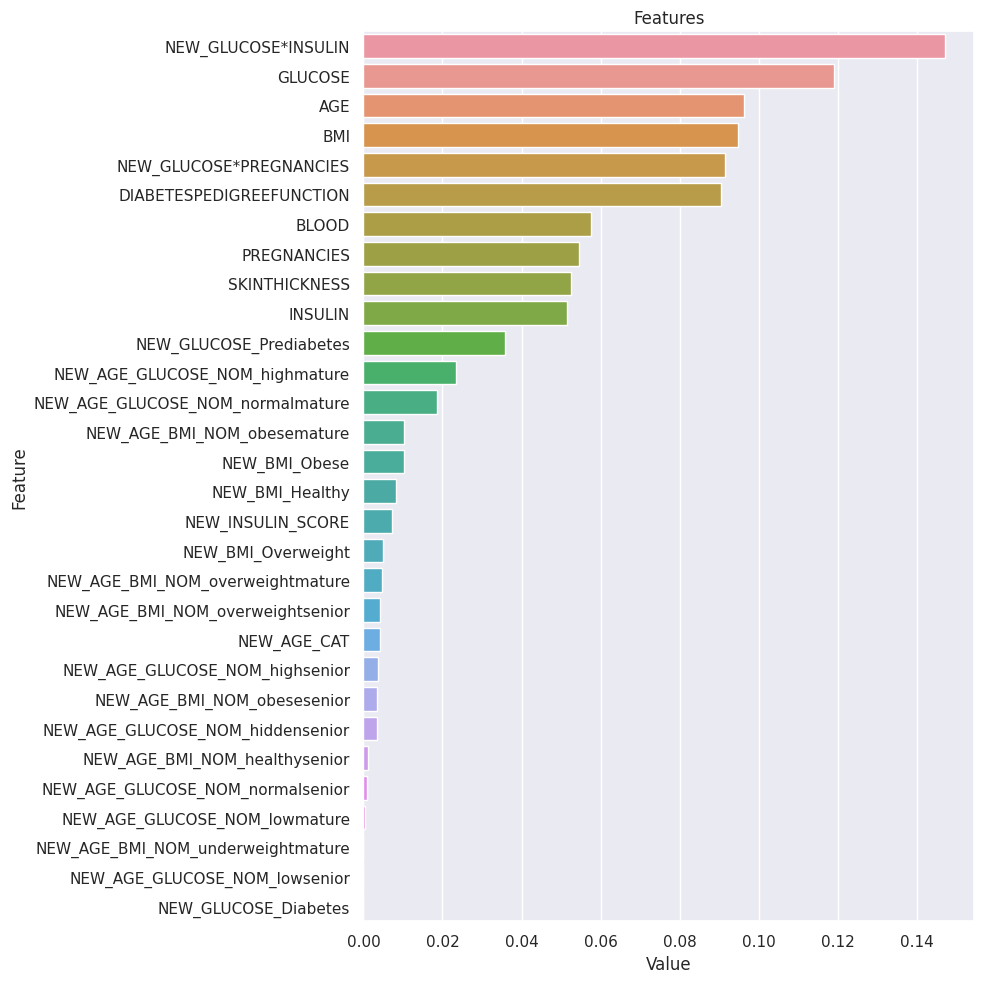

In [49]:
# FEATURE IMPORTANCE
feature_importance_plot(rf_model, X )